In [1]:
from interaction_inference import simulation
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tqdm

In [2]:
rng = np.random.default_rng(7)

# Interacting Birth Death test

Test of the downsampled scale CME for the interacting birth death model, testing the assumption that $f_{m} = \mathbb{E}[k_{c}\vert m] = \mathbb{E}[\beta_{c}\vert m] k_{tx} $ which may not hold exactly in this case

## Simulate data

In [20]:
# model parameters
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 5
}

# simulate sample
sample = simulation.gillespie_birth_death(params, 1000)

# capture efficiencies
beta = rng.beta(1, 2, size=1000)

# downsample
x1_sample = [x[0] for x in sample]
x2_sample = [x[1] for x in sample]
x1_downsampled = rng.binomial(x1_sample, beta)
x2_downsampled = rng.binomial(x2_sample, beta)
downsampled = list(zip(x1_downsampled, x2_downsampled))

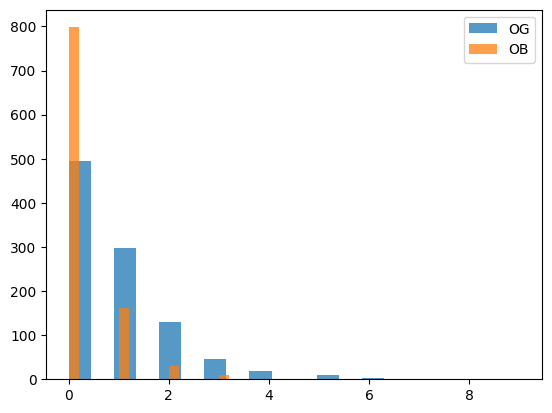

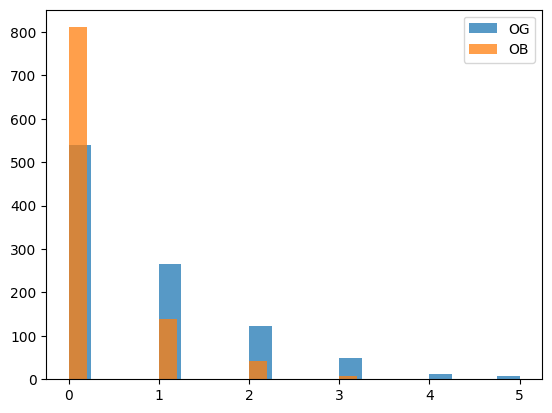

In [21]:
plt.hist(x1_sample, alpha=0.75, label="OG", bins=20);
plt.hist(x1_downsampled, alpha=0.75, label="OB", bins=20);
plt.legend()
plt.show()
plt.hist(x2_sample, alpha=0.75, label="OG", bins=20);
plt.hist(x2_downsampled, alpha=0.75, label="OB", bins=20);
plt.legend()

In [5]:
def bootstrap_p(downsampled, N=1000, n=1000):
    '''
    N: number of bootstrap samples
    n: size of each bootstrap sample
    '''

    x1_downsampled = [x[0] for x in downsampled]
    x2_downsampled = [x[1] for x in downsampled]

    # number of m's observed
    M1 = int(np.max(x1_downsampled)) + 1
    M2 = int(np.max(x2_downsampled)) + 1

    # setup estimates for p(m1, m2) for each m in each resample
    estimates = np.empty((N, M1, M2))

    # for each bootstrap sample
    for i in range(N):

        # resample
        boot = rng.choice(np.array(downsampled), size=n)

        # compute estimates over resample
        for m1 in range(M1):
            for m2 in range(M2):
                estimates[i, m1, m2] = int(((boot == [m1, m2]).sum(axis=1) == 2).sum()) / n#int((boot == (m1, m2)).sum()) / n

    # take quantiles across bootstrap samples
    intervals = np.quantile(estimates, [0.025, 0.975], axis=0)

    return intervals

## Bootstrap p(m1, m2)

Bootstrap observed count distribution

In [6]:
p_est = bootstrap_p(downsampled)

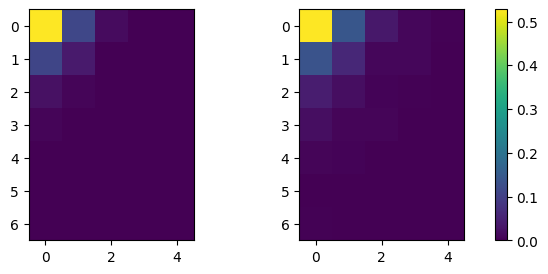

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
lb = axs[0].imshow(p_est[0, :, :])
ub = axs[1].imshow(p_est[1, :, :])
cbar = plt.colorbar(lb, ax=axs)

In [8]:
# exact p(m) [ONLY FOR k_reg = 0]
M1 = 5
M2 = 5
dist = scipy.stats.poisson.pmf(range(M1), params['k_tx_1'] / params['k_deg_1'])[:, None] * scipy.stats.poisson.pmf(range(M2), params['k_tx_2'] / params['k_deg_2'])[None, :]

## Direct estimation of f_m

Since there are multiple transcription rates we now have 2 rates, and index by pairs of states:

$$ \mathbb{E}[\beta_{c} \vert (m_{1}, m_{2})] k_{tx_1} \quad \mathbb{E}[\beta_{c} \vert (m_{1}, m_{2})] k_{tx_2} $$

So instead define:

$$ f_{m_{1},m_{2}} = \mathbb{E}[\beta_{c} \vert (m_{1}, m_{2})] $$

In [9]:
def fm_bootstrap(m1, m2, beta, downsampled):

    # capture for cells with downsampled counts (m1, m2)
    beta_m = beta[(downsampled == np.array([m1, m2])).sum(axis=1) == 2]

    # bootstrap E[beta|m]
    N = 1000
    n = beta_m.size
    boot = rng.choice(beta_m, (N, n))
    estimates = boot.mean(axis=1)
    fm = np.quantile(estimates, [0.025, 0.975], axis=0) # * params['k_tx']

    return fm

In [10]:
# estimate f's
M1 = 5
M2 = 5
fms_lb = np.zeros((M1, M2))
fms_ub = np.zeros((M1, M2))
for m1 in range(M1):
    for m2 in range(M2):
        lb, ub = fm_bootstrap(m1, m2, beta, downsampled)
        fms_lb[m1, m2] = lb
        fms_ub[m1, m2] = ub

C:\Users\willi\AppData\Local\Temp\ipykernel_7736\4286958032.py:10: RuntimeWarning: Mean of empty slice.
  estimates = boot.mean(axis=1)
c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


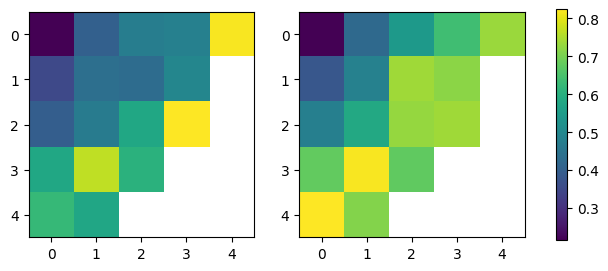

In [11]:
# display
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
lb = axs[0].imshow(fms_lb)
ub = axs[1].imshow(fms_ub)
cbar = plt.colorbar(lb, ax=axs)

## Exact values satisfy CME (K_reg = 0 CASE WHEN EXACT P(M) AVAILABLE)

In [82]:
def fm1m2(m1, m2):
    fm = 0
    for b in beta:
        fm += b * scipy.stats.poisson.pmf(m1, b*params['k_tx_1']/params['k_deg_1']) * scipy.stats.poisson.pmf(m2, b*params['k_tx_2']/params['k_deg_2']) * (1 / len(beta)) / p[m1, m2]
    return fm

In [83]:
M1 = 5
M2 = 5
p = np.zeros((M1, M2))
for b in beta:
    p += scipy.stats.poisson.pmf(range(M1), b * params['k_tx_1'] / params['k_deg_1'])[:, None] * scipy.stats.poisson.pmf(range(M2), b * params['k_tx_2'] / params['k_deg_2'])[None, :] / len(beta)

In [ ]:
m1, m2 = 1, 0

fm1m2(m1 - 1, m2) * params['k_tx_1'] * p[m1 - 1, m2] + \
fm1m2(m1, m2 - 1) * params['k_tx_2'] * p[m1, m2 - 1] + \
params['k_deg_1'] * (m1 + 1) * p[m1 + 1, m2] + \
params['k_deg_2'] * (m2 + 1) * p[m1, m2 + 1] + \
params['k_reg'] * (m1 + 1) * (m2 + 1) * p[m1 + 1, m2 + 1] - \
(fm1m2(m1, m2) * params['k_tx_1'] + \
 fm1m2(m1, m2) * params['k_tx_2'] + \
 params['k_deg_1'] * m1 + \
 params['k_deg_2'] * m2 + \
 params['k_reg'] * m1 * m2) * p[m1, m2]

## Estimated f_m1_m2 in CME

The CME on the downsampled scale is now (with the redefined f's):

\begin{align*}
0 &= f_{m_{1} - 1, m_{2}} k_{tx_1} p(m_{1} - 1, m_{2}) \\
&+ f_{m_{1}, m_{2} - 1} k_{tx_2} p(m_{1}, m_{2} - 1) \\
&+ k_{deg_1} (m_{1} + 1) p(m_{1} + 1, m_{2}) \\
&+ k_{deg_2} (m_{2} + 1) p(m_{1}, m_{2} + 1) \\
&+ k_{reg} (m_{1} + 1) (m_{2} + 1) p(m_{1} + 1, m_{2} + 1) \\
&- (f_{m_{1}, m_{2}} k_{tx_1} + f_{m_{1}, m_{2}} k_{tx_2} + k_{deg_1} m_{1} + k_{deg_2} m_{2} + k_{reg} m_{1} m_{2}) p(m_{1}, m_{2})
\end{align*}

In [79]:
# model parameters
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

# simulate sample
sample = simulation.gillespie_birth_death(params, 1000)

# capture efficiencies
beta = rng.beta(1, 2, size=1000)

# downsample
x1_sample = [x[0] for x in sample]
x2_sample = [x[1] for x in sample]
x1_downsampled = rng.binomial(x1_sample, beta)
x2_downsampled = rng.binomial(x2_sample, beta)
downsampled = list(zip(x1_downsampled, x2_downsampled))

In [80]:
# estimate p(m)'s
p_est = bootstrap_p(downsampled)

# estimate f_m's
M1 = p_est.shape[1]
M2 = p_est.shape[2]
print(M1, M2)
fm_est = np.empty((2, M1, M2))
for m1 in range(M1):
    for m2 in range(M2):
        lb, ub = fm_bootstrap(m1, m2, beta, downsampled)
        fm_est[0, m1, m2] = lb
        fm_est[1, m1, m2] = ub

5 5


C:\Users\willi\AppData\Local\Temp\ipykernel_7736\4286958032.py:10: RuntimeWarning: Mean of empty slice.
  estimates = boot.mean(axis=1)


In [81]:
for m1 in range(M1 - 1):
    for m2 in range(M2 - 1):

        # avoid issues with [- 1] indexing in tx rates when m1 / m2 = 0
        if m1 == 0:
            tx_1_lb = 0
            tx_1_ub = 0
        else:
            tx_1_lb = fm_est[0, m1 - 1, m2] * params['k_tx_1'] * p_est[0, m1 - 1, m2]
            tx_1_ub = fm_est[1, m1 - 1, m2] * params['k_tx_1'] * p_est[1, m1 - 1, m2]

        if m2 == 0:
            tx_2_lb = 0
            tx_2_ub = 0
        else:
            tx_2_lb = fm_est[0, m1, m2 - 1] * params['k_tx_2'] * p_est[0, m1, m2 - 1]
            tx_2_ub = fm_est[1, m1, m2 - 1] * params['k_tx_2'] * p_est[1, m1, m2 - 1]

        # lower bound
        lb = tx_1_lb + \
            tx_2_lb + \
            params['k_deg_1'] * (m1 + 1) * p_est[0, m1 + 1, m2] + \
            params['k_deg_2'] * (m2 + 1) * p_est[0, m1, m2 + 1] + \
            params['k_reg'] * (m1 + 1) * (m2 + 1) * p_est[0, m1 + 1, m2 + 1] - \
            (fm_est[1, m1, m2] * params['k_tx_1'] + \
            fm_est[1, m1, m2] * params['k_tx_2'] + \
            params['k_deg_1'] * m1 + \
            params['k_deg_2'] * m2 + \
            params['k_reg'] * m1 * m2) * p_est[1, m1, m2]

        # lower bound
        ub = tx_1_ub + \
            tx_2_ub + \
            params['k_deg_1'] * (m1 + 1) * p_est[1, m1 + 1, m2] + \
            params['k_deg_2'] * (m2 + 1) * p_est[1, m1, m2 + 1] + \
            params['k_reg'] * (m1 + 1) * (m2 + 1) * p_est[1, m1 + 1, m2 + 1] - \
            (fm_est[0, m1, m2] * params['k_tx_1'] + \
            fm_est[0, m1, m2] * params['k_tx_2'] + \
            params['k_deg_1'] * m1 + \
            params['k_deg_2'] * m2 + \
            params['k_reg'] * m1 * m2) * p_est[0, m1, m2]

        print(f"({m1}, {m2}): {float(lb)}, {float(ub)}")

(0, 0): -0.26566328222553953, -0.03681395685228894
(0, 1): -0.18174985818526035, 0.13002451489213074
(0, 2): -0.0964008916872833, 0.13807335962588133
(0, 3): -0.03989770324894465, 0.07203010632325027
(1, 0): -0.060580124393905144, 0.23571473788298652
(1, 1): -0.14772248441245792, 0.19886290223597147
(1, 2): -0.08916101371911772, 0.1577690959233789
(1, 3): -0.07799086046861405, 0.05170915469388064
(2, 0): -0.09755628437299453, 0.12896675617980158
(2, 1): -0.1313020393134537, 0.09514412323423044
(2, 2): -0.06448844641159474, 0.07359402373367462
(2, 3): -0.07138210282998665, 0.02613581031325747
(3, 0): -0.07787292570878177, 0.07623366046401474
(3, 1): -0.06160205796251774, 0.06812814699616815
(3, 2): nan, nan
(3, 3): nan, nan


- CME occasionaly not consistent with 0: suggests k_c = beta_c k_tx is an approximation of the downsampled model and not exactly true

- for k_reg = 0 the CME is always consistent

- Higher interaction strength causes issues for CME of (0, 0) but otherwise doesn't appear to significantly impact 'failure' rate

- BUT seems to work well enough to be a good approximate model

- NOTE limited to equations where observations of (m1, m2) are available to estimate f's